In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# class, func definition

In [13]:
def momentum_factor(ror_df,window_int,centered_func=None):
    #centered func can be any numpy func
    ror_df = np.log(ror_df+1)
    momentum_factor_df = np.exp(ror_df.rolling(window_int,axis=0).sum())-1
    momentum_factor_df.dropna(axis=0,inplace=True)
    if centered_func is not None:
        subtract_val_df = momentum_factor_df.apply(axis=1,func=centered_func,result_type='broadcast')
        momentum_factor_centered_df = momentum_factor_df - subtract_val_df
        return momentum_factor_centered_df
    return momentum_factor_df

#teade account class, including execution func
class position:
    def __init__(self,gross_exposure_float,fix_notion_bool:bool=True):
        self.fix_notion_bool = fix_notion_bool
        self.init_exposure_float = gross_exposure_float
        self.gross_exposure_float = gross_exposure_float
        self.cash_float = 0
        self.asset_val_float = gross_exposure_float
        self.position = pd.DataFrame()
        self.proceed_from_short_sale = 0
        self.last_val_array = 0
        self.asset_list = [gross_exposure_float]
        self.ret_left = 0
        self.ret_left_list = [0]
    def asset_val(self,price_array,fix_notion_bool:bool):
        cur_val_array = self.position.iloc[-1,:].values*price_array
        val_chg_float = (cur_val_array-self.last_val_array).sum()

        #capital gain tax
        if val_chg_float > 41675 and val_chg_float<459750:
            val_chg_float = (1-0.15)*val_chg_float
        elif val_chg_float>459750:
            val_chg_float = (1-0.2)*val_chg_float

        self.gross_exposure_float += val_chg_float
        self.asset_val_float = self.cash_float+self.gross_exposure_float+self.ret_left
        if fix_notion_bool==False:
            left_float = self.asset_val_float-self.init_exposure_float-self.ret_left
            self.ret_left += left_float
            self.gross_exposure_float-=left_float
            self.ret_left_list.append(self.ret_left)
    def order_execute(self,weights_df,price_df,
                      slippage_rate_float=0.0008,
                      brokerage_fee_rate_float = 0.01,
                      stock_loan_fee_rate_float = 0.01,
                      proceed_interest_rate_float=0.03):
        price_df = price_df.reindex(weights_df.columns,axis=1)
        execute_price_array = price_df.values*(1+np.random.normal(slippage_rate_float,0.0001,size=price_df.shape[1]))
        execute_price_array = np.nan_to_num(execute_price_array,nan=0.0)# suppose slippage follow a normal distribution
        abs_weight_df = np.abs(weights_df)
        abs_weight_df = abs_weight_df/np.sum(abs_weight_df.values) # weights constructed considering gross_exposure
        #update asset val
        if self.position.shape[0]>=1:
            self.asset_val(execute_price_array,self.fix_notion_bool)
        # switch between fix notion and actual asset
        if self.fix_notion_bool:
            exposure_weighted_df = self.init_exposure_float*(1-2*brokerage_fee_rate_float)*abs_weight_df*np.sign(weights_df.values)
        else:
            exposure_weighted_df = self.asset_val_float*(1-2*brokerage_fee_rate_float)*abs_weight_df*np.sign(weights_df.values)
        exposure_weighted_df = exposure_weighted_df.fillna(0)   # multiply original sign to distinguish long/short exposure
        shares_df = np.floor_divide(exposure_weighted_df,execute_price_array*(1+(brokerage_fee_rate_float+stock_loan_fee_rate_float)/2))
        shares_df.fillna(0,inplace=True)
        shares_array = shares_df.values
        #update cash and gross exposure
        tmp_gross_exposure_float = np.sum(np.abs(shares_array*execute_price_array))
        self.cash_float = self.asset_val_float-tmp_gross_exposure_float-self.ret_left
        self.gross_exposure_float = tmp_gross_exposure_float
        #update postion
        self.position = pd.concat([self.position,shares_df])
        #update cash
        if self.position.shape[0]>1: # if have altered position, then there exists a t least 2 position log
            val_chg_array = (self.position.iloc[-1,:]-self.position.iloc[-2,:]).values*execute_price_array
            #exposure_chg_float = val_chg_array.sum()
            brokerage_fee_float = np.abs(val_chg_array).sum()*brokerage_fee_rate_float # brokerage fee for all transactions
            #stock_loan_fee cal
            day_gap_int = (self.position.index[-1]-self.position.index[-2]).days
            stock_loan_fee_float = self.proceed_from_short_sale*(np.power(1+stock_loan_fee_rate_float-proceed_interest_rate_float,day_gap_int/252)-1) # stock loan fee - proceed interest
            #update short sale proceed
            val_array = shares_array*execute_price_array
            self.proceed_from_short_sale = -val_array[val_array<0].sum()
            #subtract cost
            self.cash_float -= stock_loan_fee_float+brokerage_fee_float
        else:
            val_array = shares_array*execute_price_array
            brokerage_fee_float = np.abs(val_array).sum() * brokerage_fee_rate_float
            self.proceed_from_short_sale = -val_array[val_array < 0].sum()
            # subtract cost
            self.cash_float -= brokerage_fee_float
        self.asset_val_float = self.gross_exposure_float+self.cash_float+self.ret_left
        self.asset_list.append(self.asset_val_float)

    #ret plotting
    def accu_ret_plot(self):
        asset_val_array = np.array(self.asset_list)-self.init_exposure_float
        plt.plot(asset_val_array,label='dollar return')
        plt.legend()
        plt.show()

def signal_weight(factor_df,long_nums = None,short_nums = None):
    if long_nums is None or short_nums is None:
        factor_postive_sum_df = factor_df.where(factor_df >= 0).sum(axis=1)
        factor_negative_sum_df = factor_df.where(factor_df < 0).sum(axis=1)
        factor_weight_neg_df = factor_df.where(factor_df >= 0).div(factor_postive_sum_df, axis=0).fillna(0)
        factor_weight_pos_df = factor_df.where(factor_df < 0).div(-factor_negative_sum_df, axis=0).fillna(0)
        factor_weight_df = factor_weight_pos_df + factor_weight_neg_df
        return factor_weight_df
    else:
        if long_nums+short_nums>factor_df.shape[1]:
            try:
                raise Exception('stocks nums sum larger than the universe of stocks.')
            except Exception as e:
                print(e)
    # quantile value
    arg_sort_df = np.argsort(factor_df,axis=1)
    K_small_loc_df = arg_sort_df.iloc[:,long_nums]
    K_large_loc_df = arg_sort_df.iloc[:,-short_nums]
    row_list = list(range(factor_df.shape[0]))
    boundary_df = pd.DataFrame([factor_df.iloc[i,[K_large_loc_df[i],K_small_loc_df[i]]].values for i in row_list])

    #only weight long nums and short nums assets
    factor1_df = factor_df.sub(boundary_df.iloc[:,0].values,axis=0)
    factor1_df = factor1_df.where(factor1_df>0).add(boundary_df.iloc[:,0].values,axis=0).fillna(0)
    factor2_df = factor_df.sub(boundary_df.iloc[:,1].values,axis=0)
    factor2_df = factor2_df.where(factor2_df<0).add(boundary_df.iloc[:,1].values,axis=0).fillna(0)
    factor_df = factor1_df+factor2_df

    factor_postive_sum_df = factor_df.where(factor_df>0).sum(axis=1)
    factor_negative_sum_df = factor_df.where(factor_df < 0).sum(axis=1)
    factor_weight_neg_df = factor_df.where(factor_df >= 0).div(factor_postive_sum_df,axis=0).fillna(0)
    factor_weight_pos_df = factor_df.where(factor_df < 0).div(-factor_negative_sum_df, axis=0).fillna(0)
    factor_weight_df = factor_weight_pos_df+factor_weight_neg_df
    return factor_weight_df

def signal_sizing(factor_df,method_str = 'linear',long_nums = None,short_nums = None):
    if method_str == 'linear':
        factor_weight_df = signal_weight(factor_df,long_nums,short_nums)
    return factor_weight_df

# (A) get data
Download SP500 constituents' data from bloomberg

In [14]:
#read data
dat_df = pd.read_csv(r'E:\study\22fall\hf\data\hw3\hw3_dat.csv',index_col=0)
dat_df.index = pd.to_datetime(dat_df.index)
dat_df = dat_df.astype(float)

# (B) signal generation

In [15]:
ror_df = dat_df/dat_df.shift(1)-1
ror_df.dropna(axis=0,inplace=True,how = 'all')
ror_df.fillna(0,inplace=True)
#centered with respect to median
mom_centered_df = momentum_factor(ror_df,5,centered_func=np.median) #5 days(weekly) accumulate ror

# (C) portfolio construction

In [16]:
#parameters
long_int = 100
short_int = 100

brokerage_fee_rate_float = 0.001
stk_loan_fee_rate_float= 0.01
pcd_interest_rate_float=0.03
alter_turn_int = 4

portfolio_weight_df = signal_sizing(mom_centered_df,'linear',long_nums=long_int,short_nums=short_int)

Although the portfolio alters on a weekly basis, making its net exposure close to 0, we can perform other sizing method
for other purpose.We can add a constraint over the sizing to make the final portfolio's net beta exposure close to zero to
 mitigate market risk or use covariance weighting following mean_variance_optimization to reduce the portfolio's risk.

In [17]:
# initialize position account
pos = position(2e6,fix_notion_bool=True) # fix notation which can be switched to False to use all exposure to invest.

# (D) Trade Execution

From last day Sep 26, roll backward every 5 days to execute trade weekly

In [18]:
for i in range(1,alter_turn_int+1):
    pos.order_execute(weights_df=portfolio_weight_df.iloc[[-(alter_turn_int-i)*5-1],:],price_df=dat_df.iloc[[-(alter_turn_int-i)*5-1],:],
                  brokerage_fee_rate_float=brokerage_fee_rate_float,stock_loan_fee_rate_float = stk_loan_fee_rate_float,
                  proceed_interest_rate_float = pcd_interest_rate_float)


Having considered brokerage fee,stk_loan_fee, short sale proceed interest, slippage in trading execution
(inside member function order_execute) and capital gain tax.

# (E) Backtest

momentum signal backtest plotting

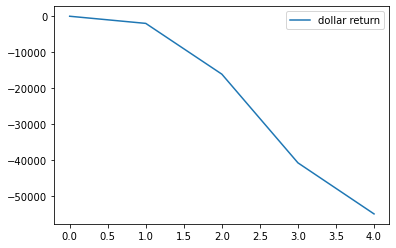

In [19]:
pos.accu_ret_plot()

Backtest reports negative return during last 4 week, which shows that momentum factor recently is not very effective.

Trying to alter some parameters

(1) Below is -momentum signal's backtest

In [20]:
portfolio_weight_df = signal_sizing(-mom_centered_df,'linear',long_nums=long_int,short_nums=short_int)
pos2 = position(2e6,fix_notion_bool=True)

for i in range(1,alter_turn_int+1):
    pos2.order_execute(weights_df=portfolio_weight_df.iloc[[-(alter_turn_int-i)*5-1],:],price_df=dat_df.iloc[[-(alter_turn_int-i)*5-1],:],
                  brokerage_fee_rate_float=brokerage_fee_rate_float,stock_loan_fee_rate_float = stk_loan_fee_rate_float,
                  proceed_interest_rate_float = pcd_interest_rate_float)

negative momentum signal backtest plotting

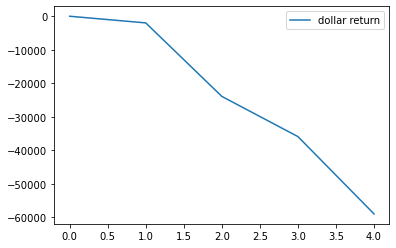

In [21]:
pos2.accu_ret_plot()

negative momentum signal is also not very effective.

(2) reduce constituents

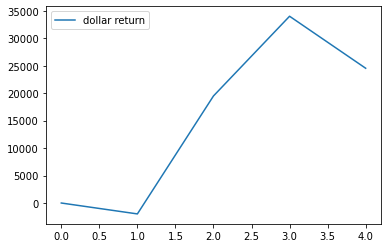

In [22]:
long_int = 2
short_int = 2

portfolio_weight_df = signal_sizing(mom_centered_df,'linear',long_nums=long_int,short_nums=short_int)
pos3 = position(2e6,fix_notion_bool=True)

for i in range(1,alter_turn_int+1):
    pos3.order_execute(weights_df=portfolio_weight_df.iloc[[-(alter_turn_int-i)*5-1],:],price_df=dat_df.iloc[[-(alter_turn_int-i)*5-1],:],
                  brokerage_fee_rate_float=brokerage_fee_rate_float,stock_loan_fee_rate_float = stk_loan_fee_rate_float,
                  proceed_interest_rate_float = pcd_interest_rate_float)
pos3.accu_ret_plot()

It reports postive return, which shows that momentum maybe only effective in stks with extreme momentum signal.